# Differential Expression Analysis
Salmon was used to obtain counts and eggnog-mapper was used to obtain functional annotation. 

We first read in packages from Bioconductor to import the data and to use the DESeq2 package. Bioconductor requires a specific version of R to run (likely the most recent) I had troubles initially but once I created a conda environemnt with the most recent R version, Bioconductor worked fine. 

#note about loading and installing tidyverse -it was working but stoped working, I tried installing it to conda which took forever! Conda found some conflicts and searched all packages in my environment-

In [1]:
#if (!require("BiocManager", quietly = TRUE))
  #install.packages("BiocManager")
#BiocManager::install(c("tximport","DESeq2"))        #I think I have already installed this an do not need to every time?
#BiocManager::install(c("apeglm"))
library('tximport')
library('DESeq2')
#install.packages(c("dplyr","tidyr","ggplot2","gplots","NMF",'RColorBrewer','pheatmap','hexbin'))
library('tidyr')
library('gplots')
library('RColorBrewer')
library('NMF')
library('ggplot2')
library("pheatmap")
library('hexbin')
library('dplyr')

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

ERROR: Error in library("gplots"): there is no package called ‘gplots’


# 1. Using the tximport function, read in the files.  

The tximport will create a list of matricies. We use the column names of the counts matrix to create rownames for the samples matrix. 

### Locate directory with files and name it as dir. 
Create a vector called files for all salmon quantification files. Create, or read in, a csv file with sample names referencing the files in the files vector. We will create the names of each item in vector files using the samples csv. Read in the files using file.path to feed in the dir variable before each file name in the vector files.  

 Note: you can only read in files associated with the same reference transcriptome together.



In [2]:
dir <-  "/work/nclab/lucy/SAB/Assembly/04/salmon"
#list.files(dir)

### First, we construct a df of metadata for the transcriptome. 
This includes column 'id' with sample id's I have used in my personal notes, column 'isolate' with the isolate number (4,6,8, or 13), column 'treatment' with treatment for each, and column 'replicate'. Basically, the 2-3 columns are info from column 1 broken up. 

### Then, using file.path, point R to the location of all the salmon quant files for this transcriptome
This will create a list of all the file location and names. Using the id column from sample metadata, name each file in the list. This name will better represent to us what we are looking at later. 

### Finally, check that all files do exist

In [3]:
counts_metadata <- data.frame(
    id=c("4add_backA","4add_backB","4pFe21_9A","4pFe21_9B","4pFe21_9C"),
    isolate=rep_len(4,5),
    treatment=c(rep_len("add_back",2),rep_len("pFe21_9",3)),
    replicate=c('A','B','A','B','C'))



files <- file.path(dir, list.files(dir, pattern=".sf",recursive = TRUE))

names(files) <- paste0(
    counts_metadata$id)

#files

all(file.exists(files))

[1] TRUE

### Now we can read in our list of files using tximport. 
Ensure the rownames for counts_metadata is equal to the column names of the raw_counts file you just created and check out the top few rows of the data. 

In [4]:
raw_counts <- tximport(files, type='salmon',txIn=TRUE, txOut = TRUE) #should this be true? transcript level data?

rownames(counts_metadata) <- colnames(raw_counts$counts)

all(rownames(counts_metadata)==colnames(raw_counts))

#raw_counts[,rownames(counts_metadata)]

reading in files with read_tsv

1 
2 
3 
4 
5 




[1] TRUE

if I sum up all counts from the open reading frames from Salmon output, there should be less than th enumber of reads I began my assembly with because about 45% of reads were mapped for quantification. 

In [5]:
my_counts <- raw_counts$counts 
myTPM <-  raw_counts$abundance

colSums(my_counts) #total number of reads mapping to my reference (the trranslated salmon pojbect) per same
colSums(myTPM)
head(my_counts)


4add_backA 4add_backB  4pFe21_9A  4pFe21_9B  4pFe21_9C 
   1283802    2350598    1928238    2310138    1748058

4add_backA 4add_backB  4pFe21_9A  4pFe21_9B  4pFe21_9C 
     1e+06      1e+06      1e+06      1e+06      1e+06

,4add_backA,4add_backB,4pFe21_9A,4pFe21_9B,4pFe21_9C
NODE_10000_length_2060_cov_11.205335_g5364_i0.p1,16.00,35.000,14.000,33.000,3.000
NODE_10001_length_2060_cov_5.581278_g5365_i0.p1,8.00,38.000,22.000,25.000,1.000
NODE_10002_length_2059_cov_37.920947_g5366_i0.p1,26.69,65.095,94.418,118.319,110.499
NODE_10002_length_2059_cov_37.920947_g5366_i0.p2,4.00,12.000,12.000,13.000,1.000
NODE_10003_length_2059_cov_28.617321_g5366_i1.p1,15.31,14.905,34.582,55.681,9.501
NODE_10004_length_2059_cov_25.532729_g4469_i1.p1,29.00,49.000,14.000,18.000,6.000


----------
# 2. Create DESeq data frame

We will: 
1. calculate summary stats on TPM matrix  
2. generate a deseq data set
2. filter by counts 
3. calculated DE and results
4. log fold shrinkage of effect size (for visualization)
3. pull out 100 most differentially expressed genes
4. merge the matrix of count data with the eggnog functional annotations
6. normalize the data

In [6]:
# Calculate summary stats on the my_TPM data matrix 
myTPM_stats  <-  transform(myTPM,
                          SD=rowSds(myTPM),
                          AVG=rowMeans(myTPM),
                          MED=rowMedians(myTPM))

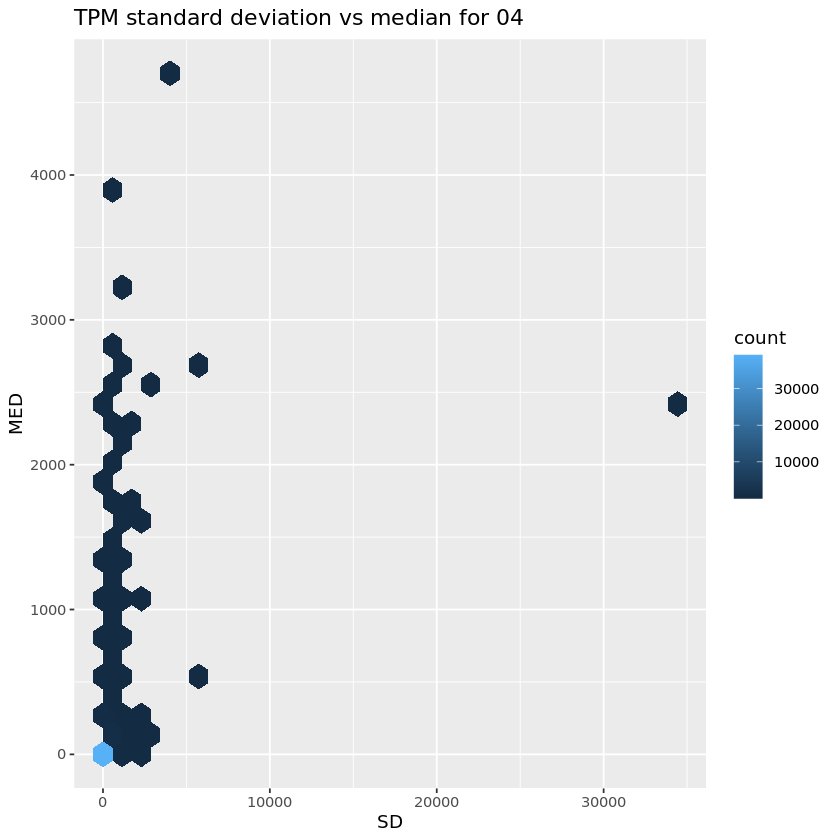

In [7]:
# plot the summary stats of the TPM data
ggplot(myTPM_stats, aes(SD, MED)) +
geom_hex(mapping = ) + labs(title="TPM standard deviation vs median for 04")

#we see a heteroscedasticity of the transcritps here. The transcripts expressed at
#the highest levels have higher varience. This is why we will represent the data 
#on a log2 scale later

#I am betting the transcripts with high expression and low variance are those which 
#are important diatoms in general and might be interesting to compare between 
#diatoms and haptophytes

In [6]:
dds <- DESeqDataSetFromTximport(
  raw_counts,
  colData=counts_metadata,
  design = ~ treatment)


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



### Let's examine the dds object

Use `assayNmes()` to print out the matrixes listed in the dds object. Let's rename the levels of the treatment column to more understandable terms from "add_back" and "pFe12.9" to "Iron_ammendment" and "Low_Iron". We are renaming the string here so we <b>must preserve the order of the levels in the original data!!!</b>. First, just print the levels of the dds then we can rename them. 

Use `relevel()` to set the Low_Iron treatment to the reference level. For the other organisms, we will treat High_Iron as the reference level. 

In [9]:
#dds
#assayNames(dds) # <--this will show us the order of the count matrixes stored in the DeSeq object

#head(adssay(dds),2) # <-- prints the second matrix, angTxLength

#colSums(assay(dds)) #<-- sums the transcripts for each sample

#rowRanges(dds) #shows the ranges of the first and last five contigs

#extract the metadata from the rowRanges function
#seqinfo(rowRanges(dds)) # <--we have none because this is a denovo analysis

#metadata provided to dds object when read into tximport
colData(dds)

#if we want to rename the collomn isolate to culture, we would do so by:
#dds$culture  <- dds$isolate

#let's rename the treatement levels
#first, we must know the order of the levels to rename them properly!!
levels(dds$treatment)
levels(dds$treatment)  <- c("Iron_ammendment","Low_Iron")

#set Low Iron as the reference treatment(level) 
dds$treatment  <- relevel(dds$treatment, "Low_Iron")
dds$treatment

DataFrame with 5 rows and 4 columns
                    id   isolate treatment   replicate
           <character> <numeric>  <factor> <character>
4add_backA  4add_backA         4  add_back           A
4add_backB  4add_backB         4  add_back           B
4pFe21_9A    4pFe21_9A         4  pFe21_9            A
4pFe21_9B    4pFe21_9B         4  pFe21_9            B
4pFe21_9C    4pFe21_9C         4  pFe21_9            C

[1] "add_back" "pFe21_9"

[1] Iron_ammendment Iron_ammendment Low_Iron        Low_Iron       
[5] Low_Iron       
Levels: Low_Iron Iron_ammendment

### How many millions of contigs were mapped to the Salmon index for each sample?

In [7]:
counts_mapped <- round(colSums(assay(dds))/1e6,1)
head(counts_mapped)

4add_backA 4add_backB  4pFe21_9A  4pFe21_9B  4pFe21_9C 
       1.3        2.4        1.9        2.3        1.7

### Pref-filtering Contigs with minimal expression
We keep the contigs which at least two samples have 10 reads total. It is reccomended that number of samples (here set to 2) is that of the smalled group size. In this case there is an n=2 for Iron_ammendment. 

In [8]:
keep <- rowSums(counts(dds)>=10)>=2 #we use 2 at the end because the group
                                                                            #with smallest n for this organism is 2
dds <- dds[keep,]



# 3. Functional annotation
------
## Read in the eggnog-mapper functional annotations

At this point, the variables/data we are working with and will move forward with are:
- counts : dataframe of salmon count data, now containing eggnog output asociated with contigs
- counts_metadata: experimental set up 
- dds: DESeq2 dataframe (list of matrixes)
- res: results dataframe from DESeq2

In [ ]:
dir2  <- "/work/nclab/lucy/SAB/Annotation/eggnog/04"
emap <- read.csv(file.path(dir2,"04.emapper.annotations"),
                 sep = "\t",
                 comment.char = "#",
                 header = FALSE,
                 na.strings = "-")[-c(1:4),]

colnames(emap) <- c(
        'query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl', 'COG_category', 'Description', 
        'Preferred_name', 'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 
        'KEGG_rclass',  'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs')

emap <- emap[, c("query", "seed_ortholog", "KEGG_ko", "GOs","PFAMs")]

kegg <- emap[,c('query','KEGG_ko')]

pfams <- emap[,c('query','PFAMs')]
str(pfams)

Go  <- emap[,c("query","GOs")]

# 4. Data transformation for visualizations
------------
- VST : variance stablizing tranformations
- rlog : regularized logarithm 

The point of these two transformations, the VST and the rlog, is to <b>remove the dependence of the variance on the mean</b>, particularly the high variance of the logarithm of count data when the mean is low.

Both VST and rlog perform log2 scale transformations, normalied with respoect to library size or other normalization factors. We can set these transformations to `blind`, which would re-estimate the dispersions using only an intercept, ignorming sample information specified by the design formula. Using `blind = TRUE` compares samples in a wholly unbiased manor from information about treatment groups. If you expect to see differences in the treatements, it is best to use `blind = FALSE`. 

In [9]:
vsd <- vst(dds,blind=FALSE)

rld <- rlog(dds, blind=FALSE)

counts_norm <- (assay(vsd))
counts_norm <- as.data.frame(counts_norm) %>%
tibble::rownames_to_column("query")

using 'avgTxLength' from assays(dds), correcting for library size

using 'avgTxLength' from assays(dds), correcting for library size



In [13]:
colData(vsd)

DataFrame with 5 rows and 4 columns
                    id   isolate       treatment   replicate
           <character> <numeric>        <factor> <character>
4add_backA  4add_backA         4 Iron_ammendment           A
4add_backB  4add_backB         4 Iron_ammendment           B
4pFe21_9A    4pFe21_9A         4 Low_Iron                  A
4pFe21_9B    4pFe21_9B         4 Low_Iron                  B
4pFe21_9C    4pFe21_9C         4 Low_Iron                  C

## 4.2 Add functional annotations to normalized counts 


In [ ]:
nrow(counts_norm)
nrow(vsd)
nrow(dds)
nrow(emap) ##??????how is the rows of emap > res?? Is this because res only has diff expressed contigs? 
#str(counts_norm)
vsd_merged  <- left_join(counts_norm, emap, 'query')

#head(vsd_merged)
nrow(vsd_merged)==nrow(counts_norm)
(nrow(vsd_merged))==(nrow(vsd))

## 4.3 Visualize effects of normalization
Plot the first vs second sample of the dds object agains the vsd and rld normalized counts. We first must `estimteSizeFactors` on the dds to account for sequencing depth (this is automatically done with `vsd()`). Then, normalize the dds counts using the log2 function, we add 1 at the end to avoid taking the log of 0; and specify `normalized=TRUE` in the non-vsd plot. Create a df of all three normaization methods with a column at the end specifying the type of transformation performed. Plot the transformed counts using hexbin from ggplot. 

https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#quantifying-with-salmon

In [10]:
dds_est <- estimateSizeFactors(dds)
df <- bind_rows(
                            as.data.frame(log2(counts(dds_est,  normalized = TRUE)[, 1:2]  + 1)) %>%
                                    mutate(transformation = "log2(x+1)"),
                            as.data.frame(assay(vsd)[, 1:2]) %>%
                                     mutate(transformation = "vst"),
                            as.data.frame(assay(rld)[, 1:2]) %>%
                                    mutate(transformation = "rlog"))

colnames(df)[1:2] <- c("x","y")

lvls <- c("log2(x+1)", "vst", "rlog")

df$transformation  <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x=x, y=y)) + geom_hex(bins=80) + coord_fixed() + facet_wrap(~transformation)

#meanSdPlot(assay(ntd))
#meanSdPlot(assay(rld))
#meanSdPlot(assay(vsd))

using 'avgTxLength' from assays(dds), correcting for library size



ERROR: Error in bind_rows(as.data.frame(log2(counts(dds_est, normalized = TRUE)[, : could not find function "bind_rows"


Note how the bins are shifted up for the vst plot. This enables us to better vissualize the distances between smaller values in the pca plots. 

## 4.4 Sample Distances
Which samples are similare which are different? Does this fit with our expectations? 

Using the `dist()` calcualte the Euclidean distances between samples, using the VSD data to ensure equal contribution among contigs. `dist()` expects rows to be different samples columns to be the contigs, so transpose the matrix using `t()`. 

In [11]:
vsd_dist <- dist(t(assay(vsd)))
vsd_dist

           4add_backA 4add_backB 4pFe21_9A 4pFe21_9B
4add_backB   98.29775                               
4pFe21_9A   142.64182  126.09792                    
4pFe21_9B   147.18906  125.57276  69.48279          
4pFe21_9C   146.26899  148.34284 143.20363 158.16673

Plot a heatmap of the distance matrix, arranging the rows and columns by the distances. Provide the sample distances from the vsd_dist to the `clustering_distance` argument to cluster sample which are must similar. 

In [12]:
vsd_dist_mat <- as.matrix(vsd_dist)
rownames(vsd_dist_mat) <- paste(vsd$id)

colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)
pheatmap(vsd_dist_mat,
        clustering_distance_rows = vsd_dist,
        clustering_distance_cols = vsd_dist,
        col = colors)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rev': could not find function "brewer.pal"


Here we see how similare the samples are to one annother. As expected, the two treatment types separate, but we see replicate C of low iron is different from the rest. 

We can also calculate a distance matrix from the original dds object using the Poisson Distance. 

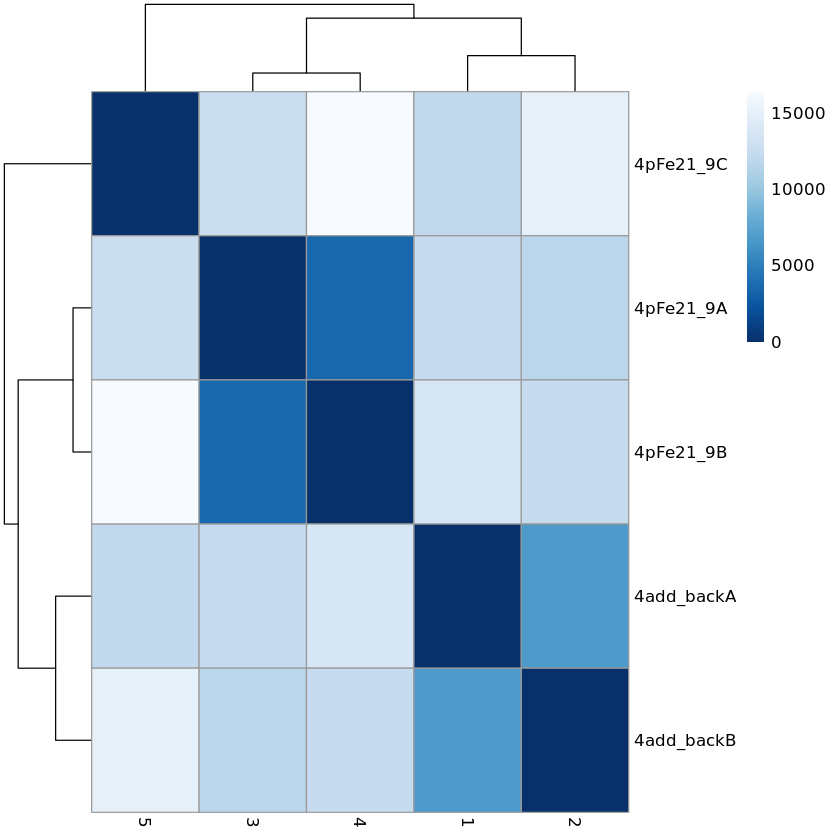

In [17]:
#install.packages('PoiClaClu')
library('PoiClaClu')
poisd <- PoissonDistance(t(counts(dds)))

poisd_mat <- as.matrix(poisd$dd)
rownames(poisd_mat) <- dds$id
pheatmap(poisd_mat, 
        clustering_distance_rows = poisd$dd,
        clustering_distance_cols = poisd$dd,
        col = colors)

## 4.5 The PCA plot also shows sample-to-sample distances

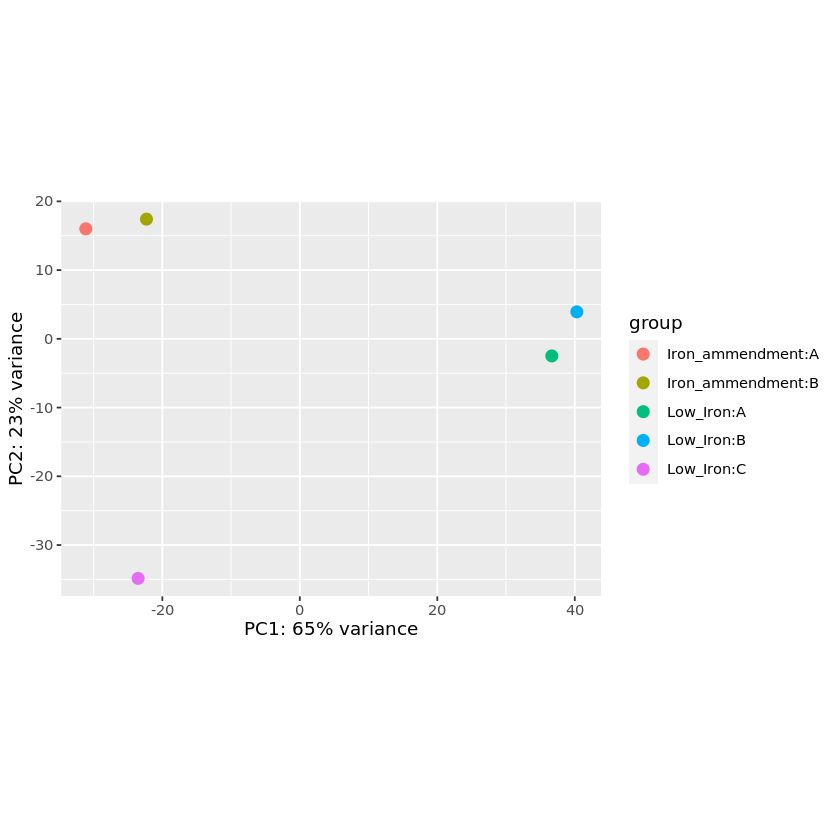

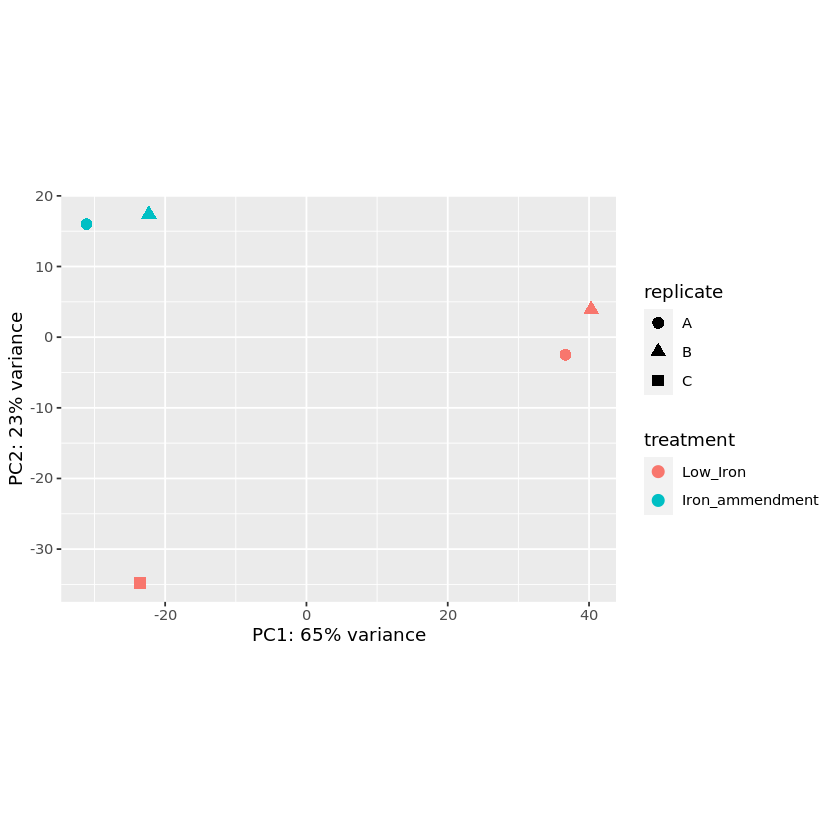

In [18]:
plotPCA(vsd, intgroup=c("treatment","replicate"))


#using ggplot to customize PCA plots
pcaData <- plotPCA(vsd, intgroup=c("treatment", "replicate"), returnData=TRUE)

percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(PC1, PC2, color=treatment, shape=replicate)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

# Tests of log2 fold change above or below a threshold
It is also possible to provide thresholds for constructing Wald tests of significance. Two arguments to the results function allow for threshold-based Wald tests: lfcThreshold, which takes a numeric of a non-negative threshold value, and altHypothesis, which specifies the kind of test. Note that the alternative hypothesis is specified by the user, i.e. those genes which the user is interested in finding, and the test provides p values for the null hypothesis, the complement of the set defined by the alternative. The altHypothesis argument can take one of the following four values, where \(\beta\) is the log2 fold change specified by the name argument, and \(x\) is the lfcThreshold.

greaterAbs - \(|\beta| > x\) - tests are two-tailed
lessAbs - \(|\beta| < x\) - p values are the maximum of the upper and lower tests
greater - \(\beta > x\)
less - \(\beta < -x\)

In [19]:
par(mfrow=c(2,2),mar=c(2,2,1,1))
ylim <- c(-2.5,2.5)
resGA <- results(dds, lfcThreshold=.5, altHypothesis="greaterAbs")
resLA <- results(dds, lfcThreshold=.5, altHypothesis="lessAbs")
resG <- results(dds, lfcThreshold=.5, altHypothesis="greater")
resL <- results(dds, lfcThreshold=.5, altHypothesis="less")
drawLines <- function() abline(h=c(-.5,.5),col="dodgerblue",lwd=2)
plotMA(resGA, ylim=ylim); drawLines()
plotMA(resLA, ylim=ylim); drawLines()
plotMA(resG, ylim=ylim); drawLines()
plotMA(resL, ylim=ylim); drawLines()

ERROR: Error in results(dds, lfcThreshold = 0.5, altHypothesis = "greaterAbs"): couldn't find results. you should first run DESeq()


# Heat map with annotations

this is taken from code from https://github.com/UVa-R-Users-Group/meetup/blob/master/2015-02-19-heat-maps/heatmaps.R


In [ ]:
#using gplots::heatmaps.2()


#using 2 pallets
pal1  <- brewer.pal(name="Blues", n=9)
pal2 <- colorRampPalette(pal1)(50)

heatmap.2(as.matrix(vsd), col=pal2, 
          hclustfun=hclust2,
          distfun=dist2,
          scale="row",
          sepcolor="black",
          dendrogram="both",
          key=TRUE,
          symkey=FALSE,
          denstiy.info="none",
          trace="none")

In [ ]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)

df <- as.data.frame(colData(dds)[,c("treatment","replicate")])

pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

pheatmap((vsd_merged[,2:6], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

# 5 Differential expression analysis
------------

## 5.1 DE extract results

All de steps are calculated in on step, DESeq(). The results are extracted with results() giving the logfold2, p-values, and adjusted p-values. Here we identify the name of the comparison we wish to do, this is becuase DEseq automatically sets the control group to the group which is first alphabetically. 
"
With no additional arguments to results, the log2 fold change and Wald test p value will be for the last variable in the design formula, and if this is a factor, the comparison will be the last level of this variable over the reference level"

In [13]:
dds <- DESeq(dds)
res <- results(dds, name="treatment_Iron_ammendment_vs_Low_Iron",
             tidy=TRUE)

head(res)
str(res)


sum(res$padj < 0.05, na.rm=T) #sum up how many adjusted p-values are significant

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



ERROR: Error: subscript contains invalid names


## 5.2 Merging the eggnog-mapper annotations file with the results file of the DESeq analysis 

First, rename the 'row' column to query in the res file. We will merge with left_join dplyr function, this should only include rows from the emap dataframe which are also found in the res dataframe; meaning we would not loose any unannotated contigs. To assure this is the case, count the number of rows for each dataframe before merging, and checked that the merged output hase equal rows to the res datatable. 

In [ ]:
colnames(res)[1]  <- "query" #rename the 'row' column to 'query' so it can be merged with eggnog output

nrow(res)
nrow(emap) ##??????how is the rows of emap > res?? Is this because res only has diff expressed contigs? 

res_merged  <- left_join(res, emap, 'query')

head(res_merged,2)

(nrow(res_merged))==(nrow(res))


## 5.3 Order the results by smallest p value and extract top 100 differentially expressed contigs

Use sumary() to view summary stats of various results data frames.
Create a table of the top 100 most differentially expressed contigs and call it top_100. Filter the mail results table by those which have significant expression, p-adjust < 0.05. 

In [ ]:
resOrdered <- res_merged[order(res_merged$pvalue),]

top_100  <- resOrdered[c(1:100),]
head(top_100)
#top 100 diff expressed contigs
#summary(top_100)

#unfiltered results
#summary(res_merged)

#all contigs with signigifcant adjusted p-values
res_Sig  <-filter(res_merged, padj < 0.1, na.rm = TRUE)
summary(res_Sig)

#order the significant congits by log2FoldChange to got those with the strongest DOWN regulation
res_Sig_down <-  res_Sig[order(res_Sig$log2FoldChange), ]
res_100_down <- res_Sig_down[c(1:100), ]

#order the significant congits by log2FoldChange to got those with the strongest UP regulation
res_Sig_up <-  res_Sig[order(res_Sig$log2FoldChange, decreasing = TRUE), ]
res_100_up <- res_Sig_up[c(1:100), ]


## 5.4 Log Fold Change Shrinkage
lfcShrink is helpful to <b>visualize</b> and <b>rank</b> genes. Here, we use the apelglm method to measure effect size shrinkage. We provide the function with the dds object and the name or number of the coefficient we want to shrink. 

We then order the results like earlier and extract the top 100 contigs

In [ ]:
resultsNames(dds)
resLFC <- lfcShrink(dds,coef='treatment_Iron_ammendment_vs_Low_Iron',
                    type='apeglm')
resLFCdf <- as.data.frame(resLFC) %>% tibble::rownames_to_column("query")


LFC_merged  <- left_join(resLFCdf, emap, 'query')

(nrow(LFC_merged))==(nrow(resLFC))

LFC_ordered <- LFC_merged[order(LFC_merged$pvalue),]
topLFC_100  <- LFC_ordered[c(1:100),]
head(topLFC_100)

## 5.6 Plotting the DE data

### 5.6.1 Plot Counts

Here we plot counts of specific contigs, grouped by the intgroup variable. The contig may be selected by rowname (contig id) or numberic index. Here, we <b>plotted the contig with the most significant change between treatments</b>. To customize these plots using ggplot, add the argument `retunData = TRUE` to output a data frame. 

In [ ]:

plotCounts(dds, gene=which.min(res$padj), intgroup="treatment", main = "Contig with smalled pvalue")

For a particular gene, a log2 fold change of -1 for condition treated vs untreated means that the treatment induces a multiplicative change in observed gene expression level of \(2^{-1} = 0.5\) compared to the untreated condition. If the variable of interest is continuous-valued, then the reported log2 fold change is per unit of change of that variable.

<b>Note on p-values set to NA</b>: some values in the results table can be set to NA for one of the following reasons:

If within a row, all samples have zero counts, the baseMean column will be zero, and the log2 fold change estimates, p value and adjusted p value will all be set to NA.
If a row contains a sample with an extreme count outlier then the p value and adjusted p value will be set to NA. These outlier counts are detected by Cook’s distance. Customization of this outlier filtering and description of functionality for replacement of outlier counts and refitting is described below
If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p value will be set to NA. Description and customization of independent filtering is described below



### 5.6.2 MA-plots 
Showing the distribution of estimated coefficients in the model. 
point out some of the most differentially expressed genes in ppt with arrow. Look for genes most differentially expressed and for those I am interested in to see where they are. 

In [ ]:
plotMA(resLFC)

# Gene Clustering

### We can cluster the genes like we clustered the samples by distance. In this case, we cluser contigs which have the highest variance across samples

Subset the top 20 most variable contigs and call it top_var, using the normalized count data vsd. Use `rowVars` to estimate variance across rows. 

Center the contigs value across samples to show the amount a contigs deviates in a sample from the average across all samples.  This will generate a heatmap of relative VST-transformed values across samples. Treatment and replicate are shown with color bars at the top of the heatmap 

In [19]:
top_var <- head(order(rowVars(assay(vsd)), decreasing = TRUE),20)

mat_var <- assay(vsd)[top_var,] #extract count values for the most differentially expressed contigs
#mat_var <- mat_var - rowMeans(mat_var) #center each cell in matrix by the avereage across samples (setting scale to true?)
anno <- as.data.frame(colData(vsd)[, c("treatment","replicate")])

pheatmap(mat_var,  annotation_col = anno, show_rownames = FALSE)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': error in evaluating the argument 'x' in selecting a method for function 'rowVars': error in evaluating the argument 'x' in selecting a method for function 'assay': object 'vsd' not found


In [ ]:
pfams  <- filter(pfams, complete.cases(PFAMs))

In [ ]:
vsd_df <- as.data.frame(assay(vsd)) %>% tibble::rownames_to_column('query')
#newrows <- c(pfams$query)
vsd_df <- vsd_df %>% filter(query %in% pfams$query)  
vsd_df <- left_join(vsd_df, pfams, by='query')
head(vsd_df)

vsd_df <- tibble::column_to_rownames(vsd_df, var= "query")
vsd_mat <- vsd_df[,-6] %>% as.matrix()
#vsd_mat = matrix of contigs which have pfam values

In [ ]:
top_var <- head(order(rowVars(vsd_mat), decreasing = TRUE),20)

mat_var <- vsd_mat[top_var,] #extract count values for the most differentially expressed contigs
mat_var <- mat_var - rowMeans(mat_var) #center each cell in matrix by the avereage across samples
anno <- as.data.frame(colData(vsd)[, c("treatment","replicate")])

pheatmap(mat_var,  annotation_col = anno, show_rownames = FALSE)

In [ ]:
order(vsd_mat,decreasing = TRUE)
#we need 
left_join(vsd_var, pfams,by='query')

## Examine ratio of small p-values for binned mean normalize count of contigs

As displayed in the MA plot, weakly expressed genes are not obserbed by differential expression analysis. This s because low read counts have high Poisson noise, uncertainties from low sampling rates drown out any biological effect. Use the results table subjected to the threshold to show what this looks like in a case wehen there are few tests with small p values. We will use `quantile()`  to bin contigs by base mean and use `cut` to rename the levels of the bins by the median point. Then we will calculate the ration of the p-value < 0.05 for each bin. 

In [ ]:
qs <- c(0, quantile(res$baseMean[res$baseMean > 0], 0:6/6))

bins <- cut(res$baseMean, qs)
levels(bins) <- paste("~", round(signif ( ( qs[-1] + qs[-length(qs) ]) / 2, 2 ) ) )
fractionSig <- tapply(res$pvalue, bins, function(p)
    mean(p < 0.05, na.rm=TRUE))
barplot(fractionSig, xlab="mean normalized count", ylab="fraction of small p values")

In [ ]:
sessionInfo()